In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import numpy as np
import torchvision 
import random,math
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from operator import attrgetter
from functools import partial
from torch.utils.data import DataLoader,default_collate,Dataset
from copy import copy
from torch.optim.lr_scheduler import ExponentialLR
from collections.abc import Mapping
from diffusers import UNet2DModel
from tqdm import tqdm
from diffusers import DDIMScheduler, DDPMScheduler
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [3]:
# Load the datasets
# Remember to pad the images with 2 pixels on each side i.e. to make the image size 32x32

batch_size = 128

transforms = T.Compose([T.ToTensor(),lambda x: 2*x - 1])

train_ds = torchvision.datasets.CIFAR10(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.CIFAR10(root = './data/valid',train = False,download = True,transform = transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([128, 3, 32, 32]) torch.Size([128])


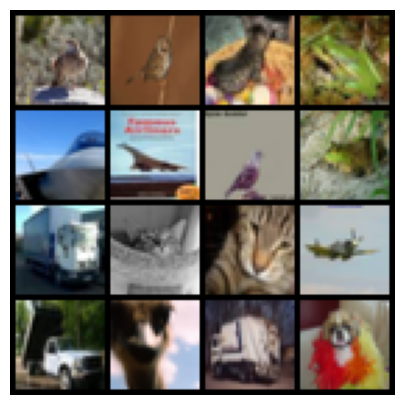

In [4]:
batch = next(iter(train_dl))
x,y = batch
print(x.shape,y.shape)

images = x[:16]/2 + 0.5
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid_img, (1,2,0)))
plt.axis('off')
plt.show()

In [5]:
class DDPM_model(nn.Module):
    def __init__(self, model,beta_min = 0.00085, beta_max = 0.012, n_steps = 1000):
        super().__init__()
        self.model = model
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        self.beta = torch.linspace(beta_min, beta_max, self.n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = self.alpha.cumprod(dim=0)
        self.sigma = self.beta.sqrt()

    def add_noise(self, x_0):
        device = x_0.device
        n = len(x_0)
        timesteps = torch.randint(0, self.n_steps, (n,), device=device)
        alphabar_t = self.alphabar.to(device)[timesteps].reshape(-1, 1, 1, 1)
        noise = torch.randn_like(x_0, device=device)
        x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
        return (x_t, timesteps.to(device)), noise

    def forward(self, x):
        return self.model.forward(*x).sample

In [6]:
def sample(sched,model,sz = (16,3,32,32)):
    preds = []
    x_t = torch.randn(sz).cuda()
    for t in tqdm(sched.timesteps,total=len(sched.timesteps)):
        with torch.no_grad(): noise = model((x_t, t))
        x_t = sched.step(noise, t, x_t).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [7]:
unet_model = UNet2DModel(in_channels=3, out_channels=3,block_out_channels=(128,256,384,512))
model = DDPM_model(unet_model, n_steps=1000)

In [8]:
epochs = 5
lr = 0.005
opt = optim.Adam(model.parameters(), lr=lr,eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))

In [9]:
def fit(model,train_dl,valid_dl,loss_func,epochs,opt,sched):
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        losses = []
        model.train()
        for xb,_ in train_dl:
            opt.zero_grad()
            xb = to_device(xb)
            (x_t, timesteps), noise = model.add_noise(xb)
            (x_t, timesteps) = to_device((x_t, timesteps))
            noise = to_device(noise)
            with torch.cuda.amp.autocast(dtype=torch.float16):
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
            losses.append(loss.item() * len(xb))
            scaler.scale(loss).backward()
            scaler.step(opt)
            sched.step()
            scaler.update()
        print(f"Epoch {epoch} train loss: {sum(losses)/len(train_ds)}")
        model.eval()
        losses = []
        with torch.no_grad():
            for xb,_ in valid_dl:
                xb = to_device(xb)
                (x_t, timesteps), noise = model.add_noise(xb)
                (x_t, timesteps) = to_device((x_t, timesteps))
                noise = to_device(noise)
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
                losses.append(loss.item() * len(xb))
        print(f"Epoch {epoch} valid loss: {sum(losses)/len(valid_ds)}")

In [10]:
# fit(model.to(def_device),train_dl,valid_dl,F.mse_loss,epochs,opt,sched)

In [11]:
# model = model.cpu()
# torch.save(model.state_dict(),"DDPM_cifar_state_dict.pth")
# torch.save(model.model.state_dict(),"DDPM_cifar_unet_state_dict.pth")

In [ ]:
model = DDPM_model(unet_model,1000)
model.load_state_dict(torch.load("DDPM_cifar_state_dict.pth",map_location=torch.device('cpu')))
model = model.to(def_device)
model.eval()

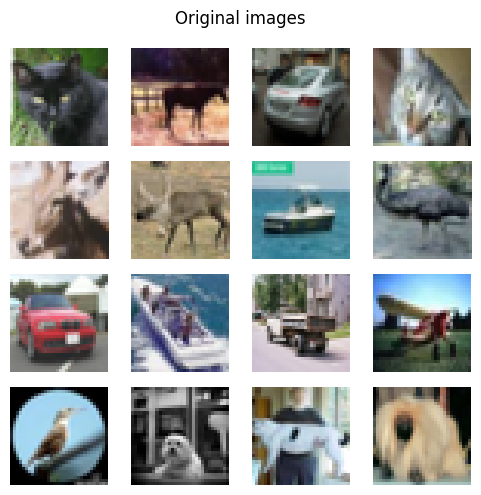

100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


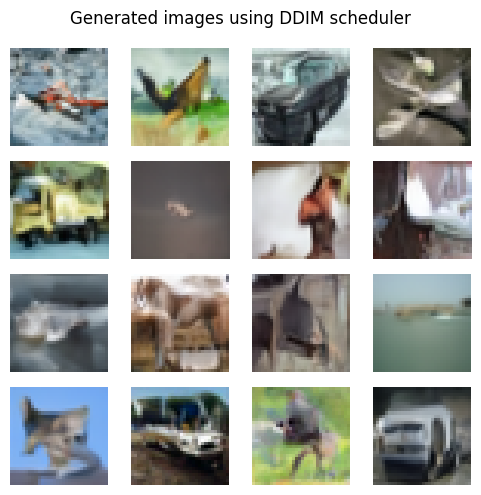

In [14]:
batch = next(iter(train_dl))
x_0 = batch[0][:16]/2+ 0.5

plt.figure(figsize=(5, 5))
plt.suptitle('Original images')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_0[i].permute(1,2,0))
    plt.axis('off')
plt.tight_layout()
plt.show()

sched = DDIMScheduler(beta_start = 0.00085, beta_end = 0.012)
sched.set_timesteps(100)
preds = sample(sched,model)

plt.figure(figsize=(5, 5))
plt.suptitle("Generated images using DDIM scheduler")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((preds[-1][i].permute(1,2,0)/2 + 0.5).clamp(0,1))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [42]:
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import display, HTML

def get_images(preds, num , l):
    return [(preds[i][num].permute(1,2,0) + 0.5).clamp(0,1) for i in l]

def animate(images):
    fig = plt.figure(figsize=(3, 3))
    plt.axis("off")
    ims = [[plt.imshow(image, animated=True, cmap='gray')] for i, image in enumerate(images)]
    plt.close()
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
    display(HTML(ani.to_html5_video()))

In [43]:
num = random.randint(0, preds[0].shape[0]-1)
for num in range(preds[0].shape[0]):
  l = l = [i for i in range(len(preds)) if i%25==0 or i > len(preds)-50] + [len(preds)-1]*10
  images = get_images(preds,num,l)
  animate(images)
